In [7]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import seaborn as sns
import pandas as pd
import sys
sys.path.append('..')
import neatplot
neatplot.set_style()
neatplot.update_rc('font.size', 20)
matplotlib.rcParams['text.usetex'] = True
%matplotlib inline

In [8]:
# sns.set_theme()

In [9]:
base_path = Path('../experiments')
baseline_path = Path('../../bac-baselines/experiments')
process_seeds = False

In [10]:
env_name = 'Plasma Tracking'

In [44]:
plasma_tracking_paths_barl = {
        200: 'barl_pt_200_2022-03-20/23-06-54/',
        800: 'barl_pt_800_2022-03-21/03-59-55/',
        10000: 'barl_bt_10k_2022-03-20/21-35-18/',
        3200: 'barl_pt_3200_2022-03-21/09-26-33/',
        10000: 'barl_pt_10000_2022-03-21/16-46-13/',
}
plasma_tracking_paths_rollout_barl ={
        200: 'rollout_barl_pt_200_2022-03-20/22-49-51/',
        
}
plasma_tracking_paths = {'Pointwise': plasma_tracking_paths_barl,
                         'Rollout': plasma_tracking_paths_rollout_barl}
plasma_tracking_paths = {
        'barl 200': 'barl_pt_200_2022-03-20/23-06-54/',
        'barl 800': 'barl_pt_800_2022-03-21/03-59-55/',
        'barl 3200': 'barl_pt_3200_2022-03-21/09-26-33/',
        #'barl 10000 (2)': 'barl_bt_10k_2022-03-20/21-35-18/',
        'barl 10000': 'barl_pt_10000_2022-03-21/16-46-13/',
        'rollout barl 200': 'rollout_barl_pt_200_2022-03-20/22-49-51/',
        'rollout barl 800': 'rollout_barl_pt_800_2022-03-22/09-13-42/',
        'rollout barl 10000': 'rollout_barl_pt_10000_2022-03-22/09-13-59/',
        'Rollout BARL': 'rollout_barl_plasma_tracking_2022-02-21/16-58-08/',
        'Rollout BARl (2)': 'rollout_barl_plasma_tracking_2022-03-22/09-51-58/',
}


In [45]:
all_paths = {# "Cartpole": cartpole_paths,
             # "Pendulum": pend_paths,
             # "Reacher": reacher_paths, 
             # 'Lava Path': lava_paths, 
             # "Reacher (tight)": reacher_tight_paths,
             # "Beta Tracking": beta_tracking_paths,
             # "Beta Tracking Fixed": beta_tracking_fixed_paths,
             # 'Swimmer': swimmer_paths,
             'Plasma Tracking': plasma_tracking_paths,
             # 'Weird Gain': weird_gain_paths,
            }
paths = all_paths[env_name]
gt = {"Pendulum": -200,
      "Cartpole": -13,
      "Reacher": -5,
      'Lava Path': -30,
      'Reacher (tight)': -8.78,
      'Swimmer': 30,
      'Beta Tracking': -2.5,
      'Beta Tracking Fixed': -2.,
      'Plasma Tracking': -5,
      'Weird Gain': -110,
     }
ylim_bottom = {
        "Pendulum": -1500,
        "Cartpole": -25,
        "Reacher": -20,
        "Lava Path": -3000,
        "Beta Tracking": -12,
        "Plasma Tracking": -40,
        "Swimmer": -30,
        "Beta Tracking Fixed": -20,
        "Weird Gain": -200,
}
gt_val = gt[env_name]
bottom_val = ylim_bottom[env_name]

In [46]:
def process_bac(data):
    returns = np.vstack(data['Eval Returns'])

    data['Eval Mean Returns'] = returns.mean(axis=1)
    data['Eval Std Returns'] = returns.std(axis=1)#  / np.sqrt(returns.shape[1])
    return data


def process_bac_seeds(path):
    data = {}
    returns = []
    for i in range(5):
        seed_path = path / f"seed_{i}" / "info.pkl"
        if not seed_path.exists():
            continue
        with seed_path.open('rb') as f:
            seed_data = pickle.load(f)
        seed_returns = np.vstack(seed_data['Eval Returns'])
        returns.append(seed_returns.mean(axis=1))
        if i == 0:
            data['Eval ndata'] = seed_data['Eval ndata']
    max_return_length = max([len(ret) for ret in returns])
    returns = [ret for ret in returns if len(ret) == max_return_length]
    returns = np.vstack(returns)
    n_trials = returns.shape[0]
    print(n_trials)
    data['Eval Mean Returns'] = returns.mean(axis=0)
    data['Eval Std Returns'] = returns.std(axis=0) / np.sqrt(n_trials)
    data['Eval Seed Returns'] = returns
    return data
            

def process_baseline(data):
    out = {}
    out['Eval Mean Returns'] = data["evaluation/Returns Mean"]
    out['Eval ndata'] = data['exploration/num steps total']
    out['Eval Std Returns'] = data['evaluation/Returns Std']
    return out


def process_baseline_seeds(path):
    if (path / f"seed_0" / "info.pkl").exists():
        return process_bac_seeds(path)
    data = {}
    returns = []
    for i in range(5):
        seed_path = path / f"seed_{i}" / "progress.csv"
        if not seed_path.exists():
            continue
        data_res = pd.read_csv(seed_path)
        returns.append(data_res["evaluation/Returns Mean"])
        if i == 0:
            data['Eval ndata'] = data_res['exploration/num steps total']
    max_return_length = max([len(ret) for ret in returns])
    returns = [ret for ret in returns if len(ret) == max_return_length]
    if len(returns) == 0:
        return {}
    returns = np.vstack(returns)
    
    data['Eval Mean Returns'] = returns.mean(axis=0)
    data['Eval Std Returns'] = returns.std(axis=0) / np.sqrt(returns.shape[0])
    data['Eval Seed Returns'] = returns
    return data

In [47]:
data = {}
for key, path in paths.items():
    print(key)
    info_path = base_path / path / 'info.pkl'
    if info_path.exists():
        with info_path.open('rb') as f:
            data[key] = process_bac(pickle.load(f))
        continue
    info_seed_path = base_path / path / 'seed_0'
    if info_seed_path.exists():
        if process_seeds:
            data[key] = process_bac_seeds(base_path / path)
        else:
            info_path = info_seed_path / 'info.pkl'
            with info_path.open('rb') as f:
                data[key] = process_bac(pickle.load(f))
        print(f'found seed data for {key}')
        continue
    baseline_exp_path = baseline_path / path / 'progress.csv'
    if baseline_exp_path.exists():
        data_res = pd.read_csv(baseline_exp_path)
        reformatted_data = process_baseline(data_res)
        data[key] = reformatted_data
        continue
    baseline_pkl_path = baseline_path / path / 'info.pkl'
    if baseline_pkl_path.exists():
        with baseline_pkl_path.open('rb') as f:
            data[key] = process_bac(pickle.load(f))
        continue
    baseline_seed_path = baseline_path / path /'seed_0'
    if baseline_seed_path.exists():
        if True:
            val = process_baseline_seeds(baseline_path / path)
            if len(val) == 0:
                continue
            data[key] = val
        else:
            data[key] = process_baseline(baseline_seed_path)
        print(f"found seed data for {key}")
        continue
    print(f"Data for {key} not found!")

barl 200
found seed data for barl 200
barl 800
found seed data for barl 800
barl 3200
found seed data for barl 3200
barl 10000
found seed data for barl 10000
rollout barl 200
found seed data for rollout barl 200
rollout barl 800
found seed data for rollout barl 800
rollout barl 10000
found seed data for rollout barl 10000
Rollout BARL
Rollout BARl (2)
found seed data for Rollout BARl (2)


In [48]:
data.keys()

dict_keys(['barl 200', 'barl 800', 'barl 3200', 'barl 10000', 'rollout barl 200', 'rollout barl 800', 'rollout barl 10000', 'Rollout BARL', 'Rollout BARl (2)'])

Text(0.5, 0.98, 'Control Performance on Plasma Tracking')

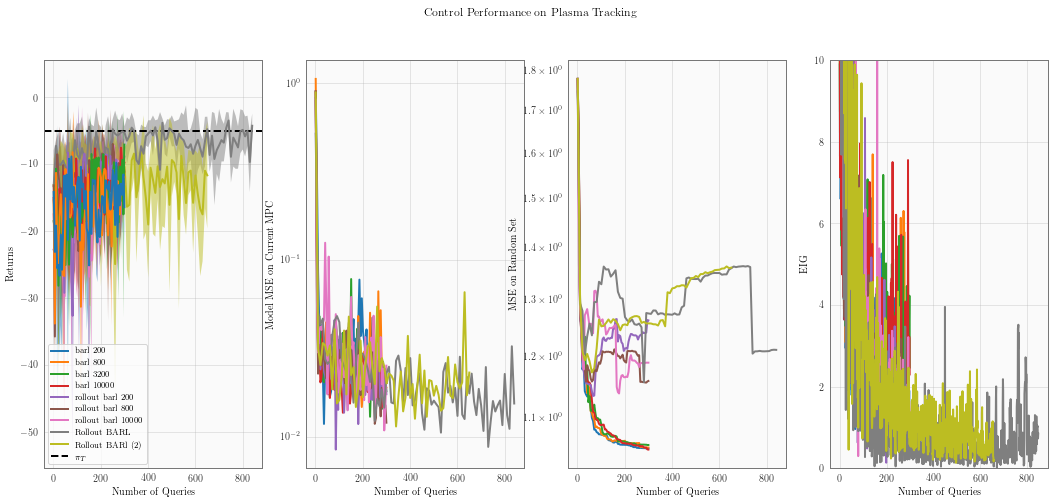

In [49]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(18, 7.5))
for i, (key, vals) in enumerate(data.items()):
    rmean = vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax1.plot(ndata, rmean, label=key, zorder=100 - i)
    ax1.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.5)
    if 'Model MSE' in vals:
        mses = vals['Model MSE']
        ax2.plot(ndata, mses, label=key)
    elif 'Model MSE (current MPC)' in vals:
        mses = vals['Model MSE (current MPC)']
        ax2.plot(ndata, mses, label=key)
    if 'Model MSE (random test set)' in vals:
        mses = vals['Model MSE (random test set)']
        ax3.plot(ndata, mses, label=key)
    if 'Acquisition Function Value' in vals:
        acqs = vals['Acquisition Function Value']
        ax4.plot(acqs, label=key)
    else:
        ax4.plot([], label=key)

        
ax1.set_xlabel('Number of Queries')
ax1.set_ylabel('Returns')
ax1.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
ax1.legend()
ax2.set_xlabel('Number of Queries')
ax2.set_ylabel('Model MSE on Current MPC')
ax3.set_ylabel("MSE on Random Set")
ax3.set_xlabel('Number of Queries')
ax4.set_xlabel('Number of Queries')
ax4.set_ylabel('EIG')
if env_name == 'Lava Path':
    ax1.set_ylim(-1000, 0)
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_ylim(0, 10)
# ax1.set_xscale('log')

fig.suptitle(f"Control Performance on {env_name}")


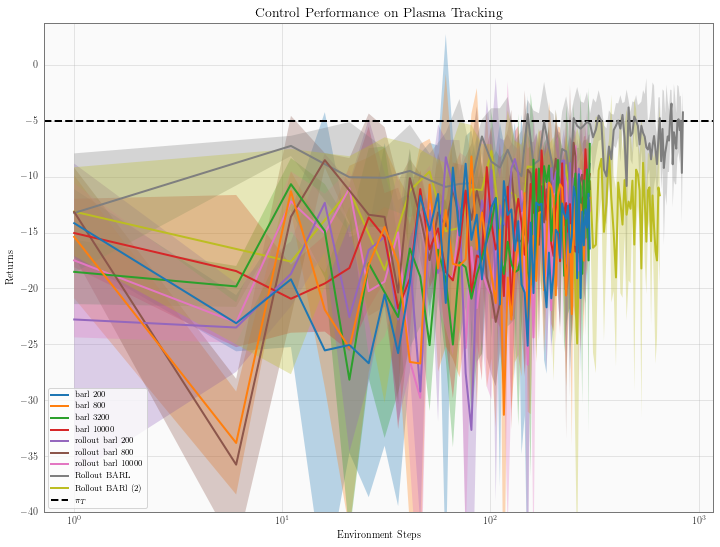

In [50]:
fig, ax = plt.subplots(figsize=(12, 9))
for i, (key, vals) in enumerate(data.items()):
    rmean = vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax.plot(ndata, rmean, label=key, zorder=100 - i)
    ax.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.3)
ax.set_xlabel('Environment Steps')
ax.set_ylabel('Returns')
ax.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
ax.legend()
ylim_top = (gt_val - bottom_val) * 0.25 + gt_val
ax.set_ylim(bottom_val, ylim_top)
ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(0, 500)
# ax.set_ylim(-10000, 0)

title = f"Control Performance on {env_name}"
ax.set_title(label=title, fontdict={'fontsize': 14})
# fig.suptitle()
plt.savefig(f'sample_complexity_{env_name}.pdf') #, bbox_inches='tight')

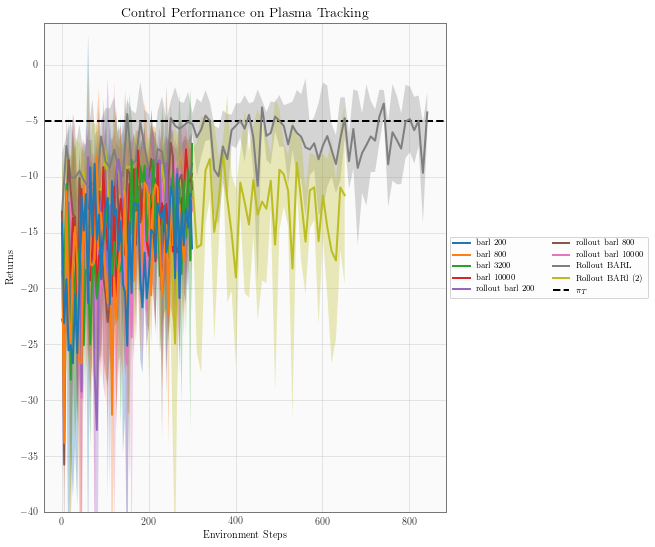

In [51]:
fig, ax = plt.subplots(figsize=(12, 9))
for i, (key, vals) in enumerate(data.items()):
    rmean = vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax.plot(ndata, rmean, label=key, zorder=100 - i)
    ax.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.3)
ax.set_xlabel('Environment Steps')
ax.set_ylabel('Returns')
ax.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
# ax.legend()
ylim_top = (gt_val - bottom_val) * 0.25 + gt_val
ax.set_ylim(bottom_val, ylim_top)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(0, 500)
# ax.set_ylim(-10000, 0)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fancybox=True)

title = f"Control Performance on {env_name}"
ax.set_title(label=title, fontdict={'fontsize': 14})
# fig.suptitle()
plt.savefig(f'legend_{env_name}.pdf') #, bbox_inches='tight')

In [52]:
print(f"Sample complexity of algorithms on {env_name}")
for key, vals in data.items():
    if 'Eval Seed Returns' in vals:
        samps = []
        for row in vals['Eval Seed Returns']:
            try:
                sample_idx = np.where(row > gt_val)[0].min()
                samps.append(vals['Eval ndata'][sample_idx])
            except ValueError:
                samps.append(np.inf)
        print(f"{key}: {sorted(samps)}")
        continue
    rmean = vals["Eval Mean Returns"]
    try:
        sample_idx = np.where(rmean > gt_val)[0].min()
        sample_complexity = vals['Eval ndata'][sample_idx]
    except ValueError:
        sample_complexity = None
    
    print(f"{key}: {sample_complexity}")

Sample complexity of algorithms on Plasma Tracking
barl 200: None
barl 800: None
barl 3200: None
barl 10000: None
rollout barl 200: None
rollout barl 800: None
rollout barl 10000: None
Rollout BARL: 151.0
Rollout BARl (2): None


Text(0.5, 1.0, 'Control Performance on Plasma Tracking')

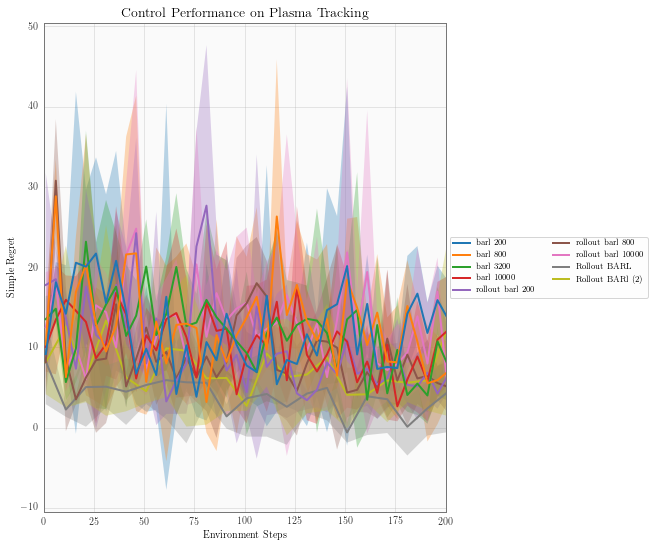

In [53]:
fig, ax = plt.subplots(figsize=(12, 9))
for i, (key, vals) in enumerate(data.items()):
    rmean = gt_val - vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    ax.plot(ndata, rmean, label=key, zorder=100 - i)
    ax.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.3)
ax.set_xlabel('Environment Steps')
ax.set_ylabel('Simple Regret')
# ax.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
# ax.legend()
ylim_top = (gt_val - bottom_val) * 0.25 + gt_val
# ax.set_ylim(bottom_val + gt_val, (gt_val - bottom_val) * 0.25)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(0, 200)
# ax.set_ylim(-10000, 0)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fancybox=True)

title = f"Control Performance on {env_name}"
ax.set_title(label=title, fontdict={'fontsize': 14})



Text(0.5, 1.0, 'Control Performance on Plasma Tracking')

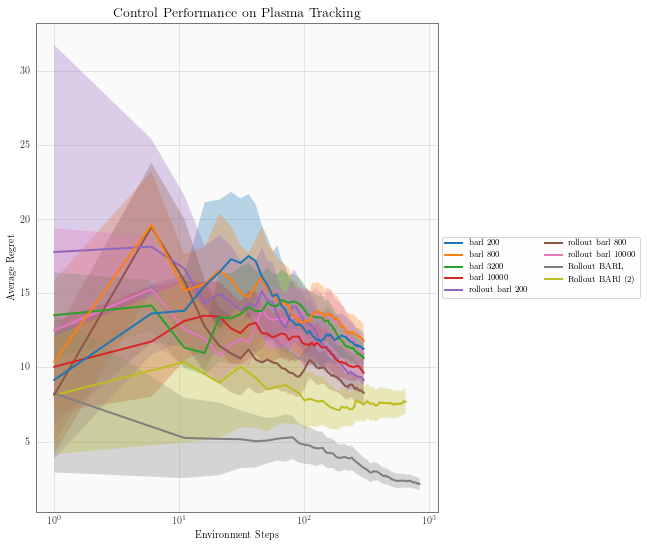

In [54]:
fig, ax = plt.subplots(figsize=(12, 9))
for i, (key, vals) in enumerate(data.items()):
    rmean = gt_val - vals["Eval Mean Returns"]
    rstderr = vals["Eval Std Returns"]
    ndata = vals['Eval ndata']
    cum_mean = np.cumsum(rmean) / np.arange(1, len(rmean) + 1)
    cum_stderr = np.sqrt(np.cumsum(np.square(rstderr))) / np.arange(1, len(rmean) + 1)
    ax.plot(ndata, cum_mean, label=key, zorder=100 - i)
    ax.fill_between(ndata, cum_mean - cum_stderr, cum_mean + cum_stderr, alpha=0.3)
ax.set_xlabel('Environment Steps')
ax.set_ylabel('Average Regret')
# ax.axhline(gt_val, color='black', linestyle='--', label=r'$\pi_T$')
# ax.legend()
# ylim_top = (gt_val - bottom_val) * 0.25 + gt_val
# ax.set_ylim(bottom_val + gt_val, (gt_val - bottom_val) * 0.25)
ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(0, 200)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fancybox=True)

title = f"Control Performance on {env_name}"
ax.set_title(label=title, fontdict={'fontsize': 14})

